In [1]:
import pandas as pd
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt
import ast
from sklearn.cluster import KMeans
from sklearn import preprocessing

In [71]:
season = 2122
teamName = "barcelona"
gw = 28
df = pd.read_csv(f"/work/assets/whoscored/{teamName}/match/{season}/eventsData/new/{season}#{gw}.csv")
df["x"] = df["x"] *1.2
df["endX"] = df["endX"] *1.2
df["y"] = df["y"] *.8
df["endY"] = df["endY"] *.8

In [72]:
passes = df[df["satisfiedEventsTypes"].apply(str).str.contains("passAccurate")]

In [73]:
passes.reset_index(drop=True,inplace=True)

In [74]:
m = len(passes)

In [75]:
def calculate_distance(x1,x2,y1,y2):
    distance = np.sqrt((x2-x1)**2 + (y2-y1)**2)
    return distance

In [76]:
distance = np.zeros(m)
for i in range(m):
    distance[i] = calculate_distance(passes['x'][i],passes['endX'][i],passes['y'][i],passes['endY'][i])

In [77]:
distance = np.around(distance,decimals=2)
distance

array([14.67, 12.64, 22.28, ..., 12.96, 26.69, 14.36])

In [78]:
passes['distance'] = distance

<ipython-input-78-24eb8daa02b5>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  passes['distance'] = distance


In [79]:
passes = passes.drop(passes.loc[(passes['endX']==0) & (passes['endY']==0)].index)
passes = passes.drop(passes.loc[(passes['endX']==120) & (passes['endY']==80)].index)

In [80]:
X = passes[['x','endX','y','endY','distance']]
scaler = preprocessing.StandardScaler().fit(X)
X_scaled = scaler.transform(X)

In [84]:
km = KMeans(n_clusters=10)
km = km.fit(X_scaled)

In [86]:
km.inertia_/len(passes)

1.3769180496736606

In [87]:
clusters = km.fit_predict(X_scaled)

In [88]:
passes['clusters'] = clusters
passes.to_csv('passes_clusters.csv',index = False)
passes = passes.sample(frac=1)

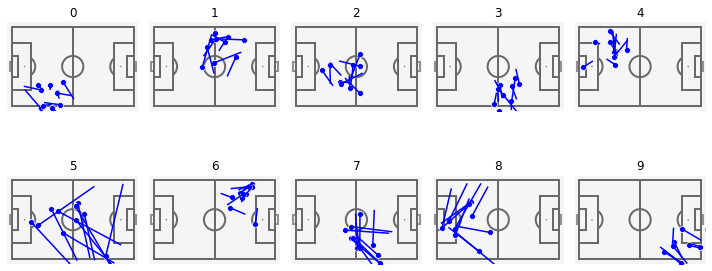

In [94]:
from mplsoccer import Pitch
pitch = Pitch(pitch_type='custom',half=False, goal_type='box', pitch_color='#f5f5f5', line_color='#696969' ,linewidth=2,pitch_length=105, pitch_width=68, constrained_layout=True)
fig, axs = pitch.draw(nrows=2, ncols=5, figsize=(10,5))
for i in range(2):
    for j in range(5):
        cluster_analysis = passes.loc[passes['clusters']==(5*i + j)][:10]
        try:
            cluster_analysis.index = np.arange(0,10,1)
        except ValueError:
            cluster_analysis.index = np.arange(0,7,1)
            pass
        axs[i,j].invert_yaxis()
        axs[i,j].plot([cluster_analysis['x'],cluster_analysis['endX']],
                              [cluster_analysis['y'],cluster_analysis['endY']], color='blue')
        
        sns.scatterplot(data=cluster_analysis,x='x',y='y',color='blue',ax=axs[i,j])
        axs[i,j].set_title(str((5*i+j)))
# plt.savefig('pass_clusters.png')

In [92]:
passes.loc[:,'clusters'].unique()

array([8, 5, 9, 6, 2, 0, 3, 4, 7, 1], dtype=int32)